# Finetuning a vanilla BART-base mdoel on FindSum dataset
<br/>
We use this model in the Briefing Agent of our project. TWe hope to develop a finetuned model that can generate clear, concise and accurate summaries for financial reports.

In [ ]:
!pip install evaluate

An outline of the FindSum dataset structure

In [ ]:
import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    print(f"\n📁 {dirname}")
    for filename in filenames:
        print(f"  - {filename}")



📁 /kaggle/input

📁 /kaggle/input/summary

📁 /kaggle/input/summary/FINDSum-ROO

📁 /kaggle/input/summary/FINDSum-ROO/roo_input_2000
  - train_roo_segment_0_input_2_1000.csv
  - val_roo_segment_0_input_2_1000.csv
  - val_roo_segment_1_input_2_1000.csv
  - test_roo_segment_0_input_2_1000.csv
  - train_roo_segment_1_input_2_1000.csv
  - test_roo_segment_1_input_2_1000.csv


Loading and preproicessing the dataset including removing missing values and tokenizing using bold **BART Tokenizer**

In [ ]:
from datasets import Dataset, DatasetDict

train_files = [
    f"{DATA_PATH}/train_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/train_roo_segment_1_input_2_1000.csv"
]

val_files = [
    f"{DATA_PATH}/val_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/val_roo_segment_1_input_2_1000.csv",
    f"{DATA_PATH}/test_roo_segment_0_input_2_1000.csv",
    f"{DATA_PATH}/test_roo_segment_1_input_2_1000.csv"
]

# Load and concat
train_df = pd.concat([pd.read_csv(f) for f in train_files], ignore_index=True)
val_df = pd.concat([pd.read_csv(f) for f in val_files], ignore_index=True)

# Drop missing
train_df = train_df.dropna(subset=["document", "summary"])
val_df = val_df.dropna(subset=["document", "summary"])

# Convert to Hugging Face Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df[["document", "summary"]]),
    "validation": Dataset.from_pandas(val_df[["document", "summary"]])
})


In [ ]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
MAX_INPUT = 1024
MAX_TARGET = 256

def preprocess(example):
    model_inputs = tokenizer(
        example["document"], max_length=MAX_INPUT, truncation=True, padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["summary"], max_length=MAX_TARGET, truncation=True, padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["document", "summary"])


Map:   0%|          | 0/33640 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/8408 [00:00<?, ? examples/s]

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 73.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.2/481.2 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.29.0
    Uninstalling huggingface-hub-0.29.0:
      Successfully uninstalled huggingface-hub-0.29.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


Training this model got 3 epochs

In [ ]:
from transformers import BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

# Define training arguments (no error now)
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_finetuned_roo",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"

)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  # see https://github.com/huggingface/transformers/issues/10628
<ipython-input-18-515132716660>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.207100,2.134006
2,2.096100,2.067156
3,2.005000,2.054371


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  logger.warning_once(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all inpu

TrainOutput(global_step=25230, training_loss=2.160236401733689, metrics={'train_runtime': 15213.979, 'train_samples_per_second': 6.633, 'train_steps_per_second': 1.658, 'total_flos': 6.15346033655808e+16, 'train_loss': 2.160236401733689, 'epoch': 3.0})

Saving this model

In [ ]:
# Save model and tokenizer
model.save_pretrained("bart_roo_finetuned")
tokenizer.save_pretrained("bart_roo_finetuned")

# Zip the folder so you can download it
!zip -r bart_roo_finetuned.zip bart_roo_finetuned


  adding: bart_roo_finetuned/ (stored 0%)
  adding: bart_roo_finetuned/merges.txt (deflated 53%)
  adding: bart_roo_finetuned/config.json (deflated 63%)
  adding: bart_roo_finetuned/special_tokens_map.json (deflated 85%)
  adding: bart_roo_finetuned/generation_config.json (deflated 47%)
  adding: bart_roo_finetuned/vocab.json (deflated 68%)
  adding: bart_roo_finetuned/model.safetensors (deflated 7%)
  adding: bart_roo_finetuned/tokenizer_config.json (deflated 75%)


Calculating the perplexity and plotting the train graphs

🧠 Final Perplexity: 7.80


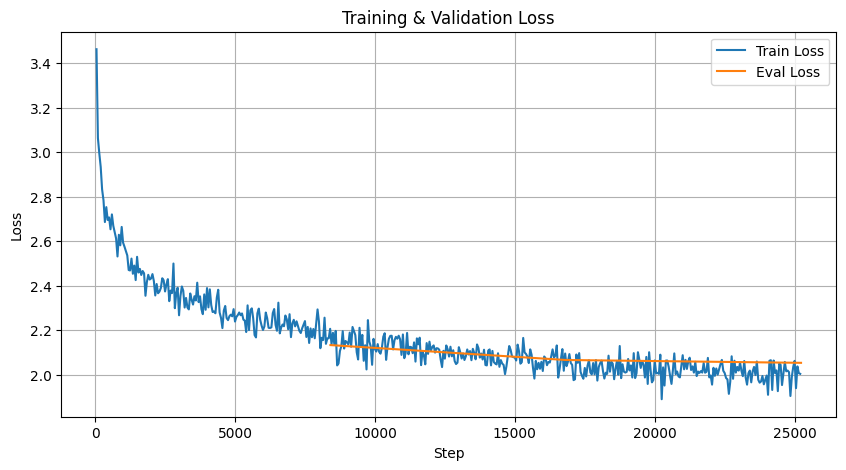

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training logs
logs = trainer.state.log_history

# Separate losses and steps
train_loss = [entry["loss"] for entry in logs if "loss" in entry and "eval_loss" not in entry]
eval_loss = [entry["eval_loss"] for entry in logs if "eval_loss" in entry]
train_steps = [entry["step"] for entry in logs if "loss" in entry and "eval_loss" not in entry]
eval_steps = [entry["step"] for entry in logs if "eval_loss" in entry]

# Calculate final perplexity
perplexity = np.exp(eval_loss[-1])
print(f" Final Perplexity: {perplexity:.2f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install rouge_score



  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e259f16dd201da03837329a2c5cc15091e3622f9f5bbab82916839a23074dff5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


Now, we compute the ROUGE scores to evaluate the performace of this model

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

# We'll run on 100 samples from the validation set
sample_val = dataset["validation"].select(range(100))

preds, refs = [], []

for example in sample_val:
    input_ids = tokenizer(
        example["document"],
        return_tensors="pt",
        max_length=1024,
        truncation=True,
        padding="max_length"
    ).input_ids.to(model.device)

    output_ids = model.generate(input_ids, max_length=256)
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    preds.append(pred)
    refs.append(example["summary"])

# Compute ROUGE
rouge_scores = rouge.compute(predictions=preds, references=refs)
for key in rouge_scores:
    print(f"{key}: {rouge_scores[key]:.4f}")


rouge1: 0.3984
rouge2: 0.1382
rougeL: 0.2091
rougeLsum: 0.2092


In [ ]:
# import matplotlib.pyplot as plt

# logs = trainer.state.log_history

# train_loss = [x["loss"] for x in logs if "loss" in x and "eval_loss" not in x]
# eval_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]
# steps = [x["step"] for x in logs if "loss" in x and "eval_loss" not in x]
# eval_steps = [x["step"] for x in logs if "eval_loss" in x]

# plt.figure(figsize=(10, 5))
# plt.plot(steps, train_loss, label="Train Loss")
# plt.plot(eval_steps, eval_loss, label="Eval Loss")
# plt.xlabel("Step")
# plt.ylabel("Loss")
# plt.title("Training and Evaluation Loss")
# plt.legend()
# plt.grid()
# plt.show()
